experiments on fair text generation

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

import numpy as np
import torch
from torch.nn import functional
import copy
import matplotlib.pyplot as plt
# import os
import json
#from core.GMC import GMC
import h5py
import cv2
from utils.utils import eval, plot_result, eval2
from transformers import AutoTokenizer, BertForPreTraining
from sklearn.model_selection import train_test_split
# os.environ["http_proxy"] = "http://127.0.0.1:7890"
# os.environ["https_proxy"] = "http://127.0.0.1:7890"

tokenizer = AutoTokenizer.from_pretrained(r'D:\\Download\\bert-base-uncased')
model = BertForPreTraining.from_pretrained(r'D:\\Download\\bert-base-uncased')

## Dataset1: real-world data

set alpha

In [3]:
alpha = 0.002

load data and split it into train sets, calibration sets and test sets.

In [23]:
data_path_1 = os.path.join(os.getcwd(), '..','datasets/FairText/Result/Result_1.h')
f1 = h5py.File(data_path_1, "r")
position, p, x, y = f1['mask'], f1['p'], np.array(list(map(lambda x:x.decode(), f1['x']))), np.array(f1['y'])
print('raw data shape: ', p.shape, len(x), len(y))
p = np.array(p)[[i for i in range(p.shape[0])], np.array(list(position)),:]
p_cal, p_test, x_cal, x_test, y_cal, y_test = train_test_split(p, x, y, test_size=0.5, random_state=43)
print('train shape: ', p_cal.shape[0], 'test shape: ', p_test.shape[0])

raw data shape:  (1500, 36, 30522) 1500 1500
train shape:  750 test shape:  750


In [24]:
accuracy_test_data_path = os.path.join(os.getcwd(), '..','datasets/FairText/Result/Accuracy_test_1.h')
f2 = h5py.File(accuracy_test_data_path, "r")
position_accu, p_accu, x_accu, y_accu = f2['mask'], f2['p'], np.array(list(map(lambda x:x.decode(), f2['x']))), np.array(f2['y'])
print('raw data shape: ', p_accu.shape, len(x_accu), len(y_accu))
p_accu = np.array(p_accu)[[i for i in range(p_accu.shape[0])], np.array(list(position_accu)),:]

raw data shape:  (1500, 36, 30522) 1500 1500


In [2]:
indicator_path = {'female':"datasets/FairText/Data/female-word.txt", 'male':"datasets/FairText/Data/male-word.txt",
            'well_profession':"datasets/FairText/Data/male-related occupations.txt", 
            'less_profession':"datasets/FairText/Data/female-related occupations.txt",
            'pleasant':"datasets/FairText/Data/pleasant-adj.txt", 'unpleasant':"datasets/FairText/Data/unpleasant-adj.txt",
            'female-adj':"datasets/FairText/Data/female-adj.txt", 'male-adj':"datasets/FairText/Data/male-adj.txt"}
indicator = {}
for key in indicator_path:
    f = open(os.path.join('..', indicator_path[key]),'r', encoding='gb2312', errors='ignore').readlines()
    indicator[key] = list(map(lambda s:s[:-1], f))

set sensitive subgroups

In [3]:
def intersect_or_not(a,b):
    # input two lists; return whether they intersect
    return len(list(set(a)&set(b)))!=0


def generate_sensitive_vector(mark, total_length=30522):
    # input a list of the position of 1; output an indicator function of it; to one hot
    vec = np.zeros(total_length)
    for position in mark:
        vec[tokenizer(position).input_ids[1]] = 1
    return vec


def generate_G():
    female = lambda x:intersect_or_not(x.split(' '), indicator['female'])
    male = lambda x:intersect_or_not(x.split(' '), indicator['male'])
    vec_list = [generate_sensitive_vector(subgroup) for subgroup in [indicator['female-adj'],indicator['male-adj'],
                indicator['less_profession'], indicator['well_profession'], indicator['pleasant'], indicator['unpleasant']]]
    G = []
    G.append(lambda x:vec_list[0]*female(x))
    G.append(lambda x:vec_list[0]*male(x))
    G.append(lambda x:-vec_list[0]*female(x))
    G.append(lambda x:-vec_list[0]*male(x))  
    G.append(lambda x:vec_list[1]*female(x))
    G.append(lambda x:vec_list[1]*male(x))
    G.append(lambda x:-vec_list[1]*female(x))
    G.append(lambda x:-vec_list[1]*male(x))  
    G.append(lambda x:vec_list[2]*female(x))
    G.append(lambda x:vec_list[2]*male(x))
    G.append(lambda x:-vec_list[2]*female(x))
    G.append(lambda x:-vec_list[2]*male(x))    
    G.append(lambda x:vec_list[3]*female(x))
    G.append(lambda x:vec_list[3]*male(x))
    G.append(lambda x:-vec_list[3]*female(x))
    G.append(lambda x:-vec_list[3]*male(x))
    G.append(lambda x:vec_list[4]*female(x))
    G.append(lambda x:vec_list[4]*male(x))
    G.append(lambda x:-vec_list[4]*female(x))
    G.append(lambda x:-vec_list[4]*male(x))  
    G.append(lambda x:vec_list[5]*female(x))
    G.append(lambda x:vec_list[5]*male(x))
    G.append(lambda x:-vec_list[5]*female(x))
    G.append(lambda x:-vec_list[5]*male(x))   
    return G

def projection(f):
    N, D = f.shape
    X = np.sort(f, axis=1)[..., ::-1]
    Xtmp = (np.cumsum(X, axis=1) - 1) * (1 / np.arange(1, D + 1))
    lamda = (1 - np.sum((X>Xtmp) * X, axis=1)) / np.sum(X>Xtmp, axis=1)
    X = np.maximum(f + lamda[:,None], 0)
    
    return X


G = generate_G()

def s(f, x, y, p):
    average_f = np.mean(f,axis=0)
    return f-average_f

run

In [4]:
import copy

def GMC(alpha, eta, x_cal, y_cal, h_cal, x_test, h_test, s, group_G, f=(lambda x:0), f_test=(lambda x:0), T=500, proj=None):
    '''
    eta:learning_rate
    x_cal:numpy
    y_cal:numpy
    h_cal:numpy
    x_test:numpy
    h_test:numpy
    s:mapping_function
    f:initial_function 
    group_G:list of group functions
    T:max_iteration
    return function f
    ''' 
    fx = f(x_cal)
    fx_test = f_test(x_test)
    n = x_cal.shape[0]
    for i in range(T):
        update = False
        for g in group_G:
            gx = np.array([g(x1)for x1 in x_cal])
            if np.sum(np.diagonal(gx@(s(fx, x_cal, y_cal, h_cal).T)))>alpha*n:
                update = True
                print(group_G.index(g))
                print(np.sum(np.diagonal(gx@(s(fx, x_cal, y_cal, h_cal).T))))
                break
        if update==False:
            print(i)
            print('end')
            return i, fx, fx_test
        else:
            gx_test = np.array([g(x1)for x1 in x_test])
            fx = fx - eta*gx
            fx_test = fx_test - eta*gx_test
            if not (proj is None):
                fx = proj(fx)
                fx_test = proj(fx_test)
    return i+1, fx, fx_test

def eval(G, s, fx, x_cal, y_cal, h_cal, accu=False):
    S = []
    n = x_cal.shape[0]
    if accu:
        return np.sum(s(fx, x_cal, y_cal, h_cal))/n
    for g in G:
        gx = np.array([g(x1)for x1 in x_cal])
        S.append(np.sum(np.diagonal(gx@(s(fx, x_cal, y_cal, h_cal).T)))/n)
    return np.array(S)

In [ ]:
def plot_result(category,result1, result2, x_label_name, y_lable_name, title, base=None):
    # 创建一个包含两个子图的图表
    fig, ax = plt.subplots(figsize=(len(category)*2,5))

    # 设置柱状图的位置
    x1 = np.arange(len(category))

    # 绘制第一个柱状图
    ax.bar(x1 - 0.2, result1, width=0.2, label='GMC')

    # 绘制第二个柱状图
    ax.bar(x1, result2, width=0.2, label='baseline')

    # 绘制横线（示例：在y=20的位置绘制横线）
    if not (base is None):
        ax.axhline(y=base, color='red', linestyle='--', label='alpha')

    # 添加标签和标题
    ax.set_xlabel(x_label_name, fontsize=18)
    ax.set_ylabel(y_lable_name, fontsize=18)
    ax.set_title(title, fontsize=18)

    # 添加图例
    ax.legend(fontsize=15)

    # 设置x轴刻度标签
    ax.set_xticks(x1)
    ax.set_xticklabels(category, fontsize=15)

    # 显示图表
    plt.show()

In [31]:
# alpha = 0.01
alpha = 0.002
eta = 0.01
vocab = 30522

fx, fx_test = p_cal, p_test
j, fx, fx_test = GMC(3/4*alpha, eta, x_cal, y_cal, p_cal, x_test, p_test, s, G, f=(lambda x:fx), f_test=(lambda x:fx_test), T=30, proj = projection)

13
2.2202455065905724
13
1.4657712025878813
13
1.2024400469819712
16
1.2020168326323828
17
3.692931532202997
17
2.7044317483702454
17
2.1668121478299813
17
1.6971020758880897
16
1.231966909099918
17
1.6254976923450037
17
1.2422102653429756
11
end


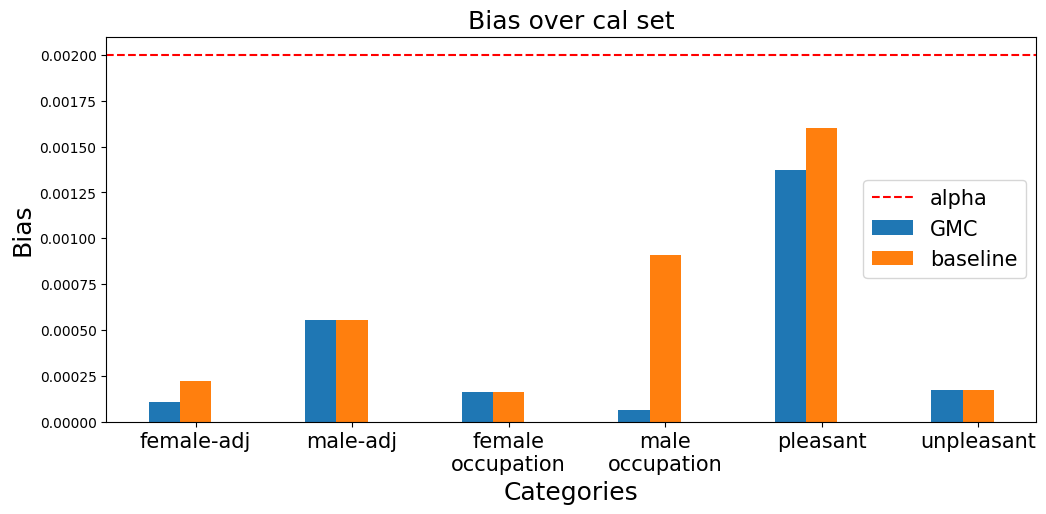

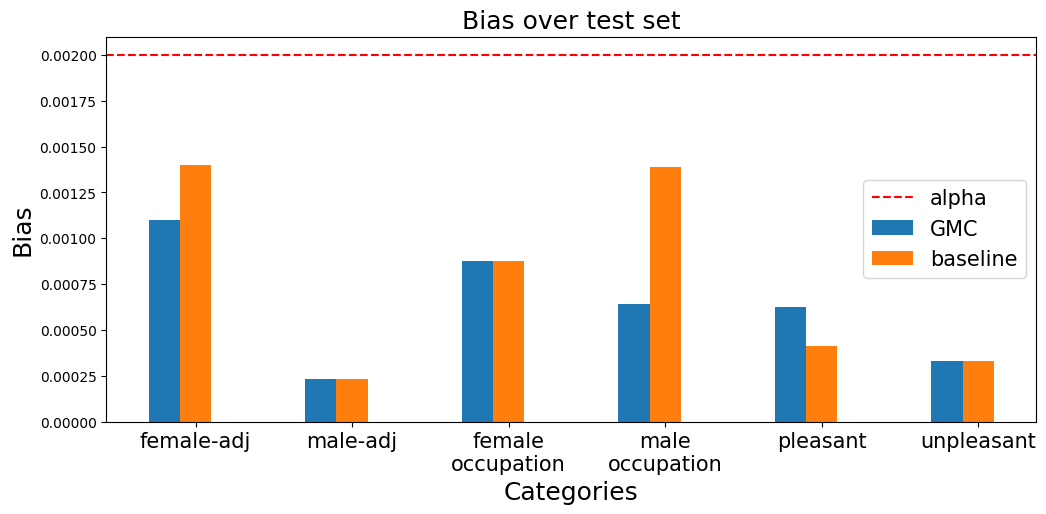

In [32]:
category = ['female-adj', 'male-adj', 'female\noccupation', 'male\noccupation', 'pleasant', 'unpleasant']
select_G = [G[0], G[4], G[8], G[12], G[16], G[20]]
gap_cal = eval(select_G, s, fx, x_cal, y_cal, p_cal)
gap_cal_b = eval(select_G, s, p_cal, x_cal, y_cal, p_cal)
gap_test = eval(select_G, s, fx_test, x_test, y_test, p_test)
gap_test_b = eval(select_G, s, p_test, x_test, y_test, p_test)
gap_cal, gap_cal_b, gap_test, gap_test_b = abs(gap_cal), abs(gap_cal_b), abs(gap_test), abs(gap_test_b) 
plot_result(category, gap_cal, gap_cal_b, 'Categories', 'Bias', 'Bias over cal set', base=alpha)
plot_result(category, gap_test, gap_test_b, 'Categories', 'Bias', 'Bias over test set', base=alpha)

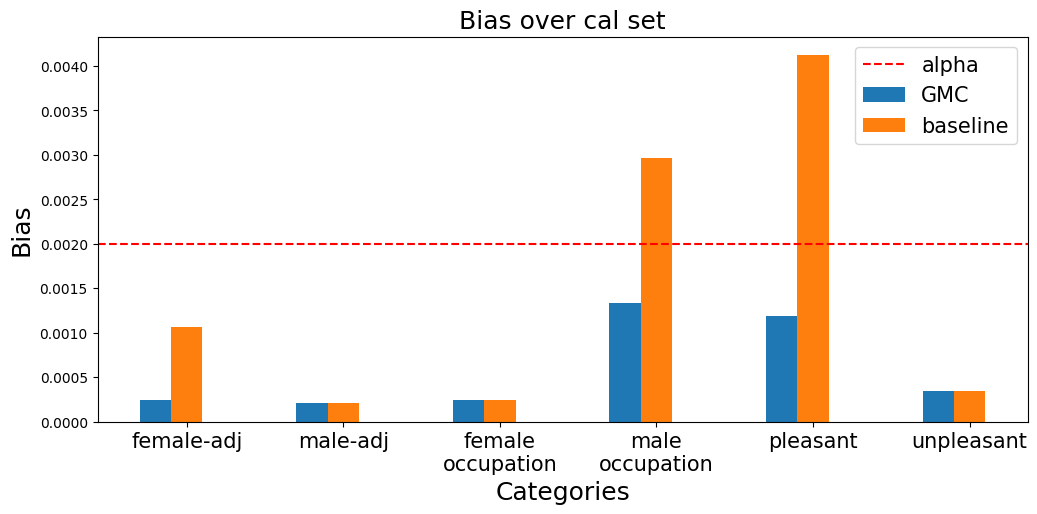

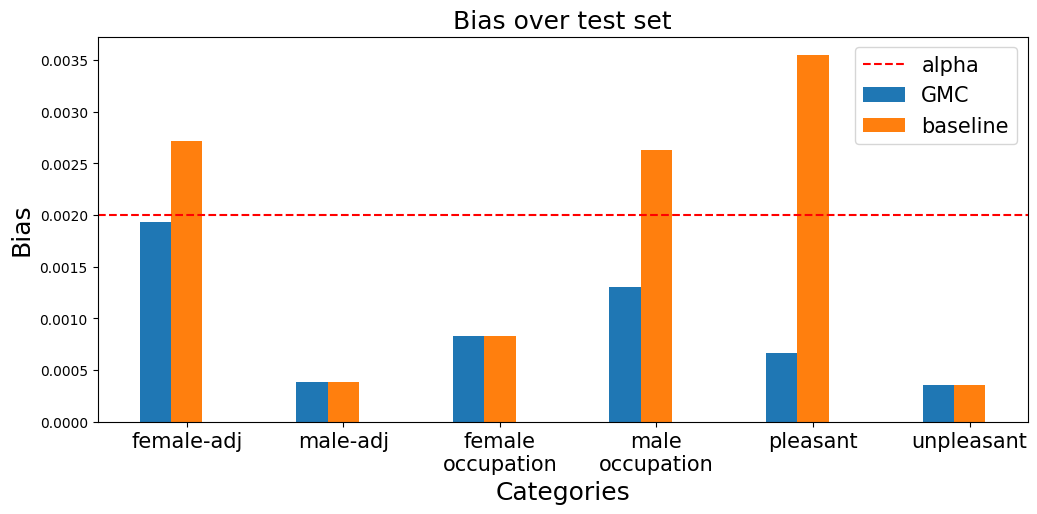

In [33]:
category = ['female-adj', 'male-adj', 'female\noccupation', 'male\noccupation', 'pleasant', 'unpleasant']
select_G = [G[1], G[5], G[9], G[13], G[17], G[21]]
gap_cal = eval(select_G, s, fx, x_cal, y_cal, p_cal)
gap_cal_b = eval(select_G, s, p_cal, x_cal, y_cal, p_cal)
gap_test = eval(select_G, s, fx_test, x_test, y_test, p_test)
gap_test_b = eval(select_G, s, p_test, x_test, y_test, p_test)
gap_cal, gap_cal_b, gap_test, gap_test_b = abs(gap_cal), abs(gap_cal_b), abs(gap_test), abs(gap_test_b) 
plot_result(category, gap_cal, gap_cal_b, 'Categories', 'Bias', 'Bias over cal set', base=alpha)
plot_result(category, gap_test, gap_test_b, 'Categories', 'Bias', 'Bias over test set', base=alpha)

In [14]:
eta = 0.01
vocab = 30522
fx, fx_accu = p_cal, p_accu
j, fx, fx_accu = GMC(3/4*alpha, eta, x_cal, y_cal, p_cal, x_accu, p_accu, s, G, f=(lambda x:fx), f_test=(lambda x:fx_accu), T=30, proj = projection)

13
1.4650540825014673
16
1.72705958903168
17
2.648048901237436
16
1.1643832743051523
17
1.9084819705080804
17
1.4216809077881103
16
1.1272004114108412
17
1.2420971857974457
8
end


In [15]:
import torch.nn.functional as F
def entropy(f, x, y, p):
    return F.cross_entropy(torch.Tensor(f),torch.Tensor(y).long()).numpy()*p.shape[0]
G_accu = [lambda x,f:1]
accu = eval(G_accu, entropy, fx_accu, x_accu, y_accu, p_accu, accu=True)
accu_b = eval(G_accu, entropy, p_accu, x_accu, y_accu, p_accu, accu=True)
print('cross entropy of our algorithm: ', accu)
print('cross entropy of the baseline: ', accu_b)

cross entropy of our algorithm:  9.929052352905273
cross entropy of the baseline:  9.928543090820312


## Dataset2: Artificial Data

In [40]:
data_path_s = os.path.join(os.getcwd(), '..','datasets/FairText/Result/Result_2.h')
f_s = h5py.File(data_path_s, "r")
position_s, p_s,x_s,y_s = f_s['mask'], f_s['p'], np.array(list(map(lambda x:x.decode(), f_s['x']))), np.array(f_s['y'])
p_s = np.array(p_s)[[i for i in range(p_s.shape[0])], np.array(list(position_s)),:]
p_s_test, p_s_cal, x_s_test, x_s_cal, y_s_test, y_s_cal = train_test_split(p_s, x_s, y_s, test_size=0.5, random_state=43)
print('Synthetic dataset...')
print('cal shape: ', p_s_cal.shape[0], 'test shape: ', p_s_test.shape[0])

accuracy_test_data_path_s = os.path.join(os.getcwd(), '..','datasets/FairText/Result/Accuracy_test_2.h')
f_s_accu = h5py.File(accuracy_test_data_path_s, "r")
position_accu_s, p_accu_s, x_accu_s, y_accu_s = f_s_accu['mask'], f_s_accu['p'], np.array(list(map(lambda x:x.decode(), f_s_accu['x']))), np.array(f_s_accu['y'])
p_accu_s = np.array(p_accu_s)[[i for i in range(p_accu_s.shape[0])], np.array(list(position_accu_s)),:]

Synthetic dataset...
cal shape:  258 test shape:  258


8
0.7092288771075914
8
0.5511001399947577
11
0.5951561972277317
3
end


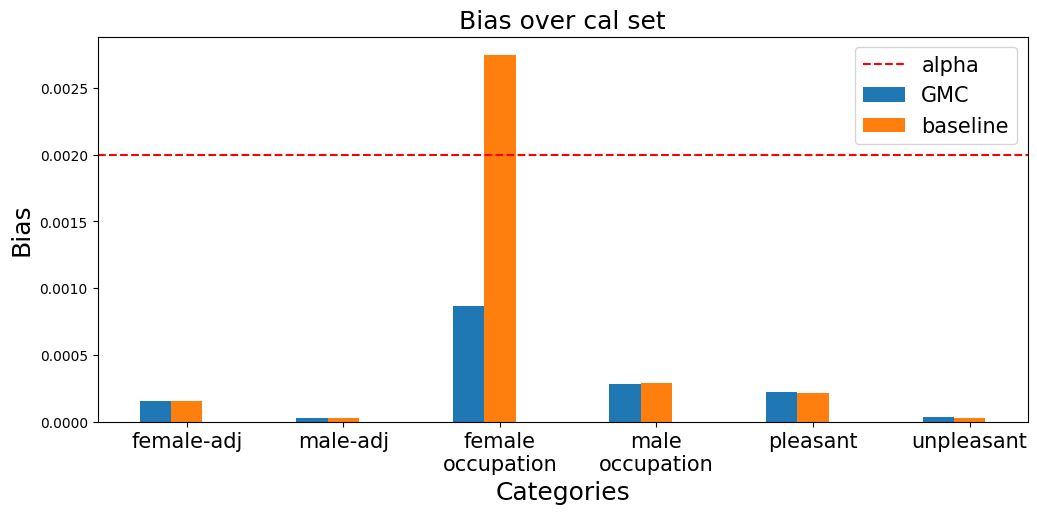

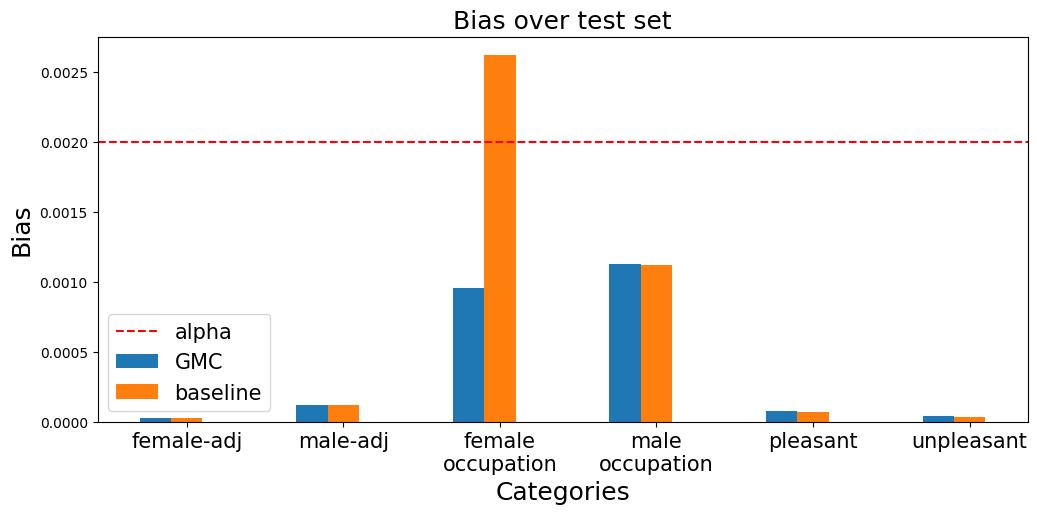

In [41]:
alpha = 0.002
# eta = 0.0002
eta = 0.001
vocab = 30522
fx, fx_test = p_s_cal, p_s_test
j, fx, fx_test = GMC(alpha, eta, x_s_cal, y_s_cal, p_s_cal, x_s_test, p_s_test, s, G, f=(lambda x:fx), f_test=(lambda x:fx_test), T=30, proj = projection)

    
category = ['female-adj', 'male-adj', 'female\noccupation', 'male\noccupation', 'pleasant', 'unpleasant']
select_G = [G[0], G[4], G[8], G[12], G[16], G[20]]
gap_cal = eval(select_G, s, fx, x_s_cal, y_s_cal, p_s_cal)
gap_cal_b = eval(select_G, s, p_s_cal, x_s_cal, y_s_cal, p_s_cal)
gap_test = eval(select_G, s, fx_test, x_s_test, y_s_test, p_s_test)
gap_test_b = eval(select_G, s, p_s_test, x_s_test, y_s_test, p_s_test)
gap_cal, gap_cal_b, gap_test, gap_test_b = abs(gap_cal), abs(gap_cal_b), abs(gap_test), abs(gap_test_b) 
plot_result(category, gap_cal, gap_cal_b, 'Categories', 'Bias', 'Bias over cal set', base=alpha)
plot_result(category, gap_test, gap_test_b, 'Categories', 'Bias', 'Bias over test set', base=alpha)

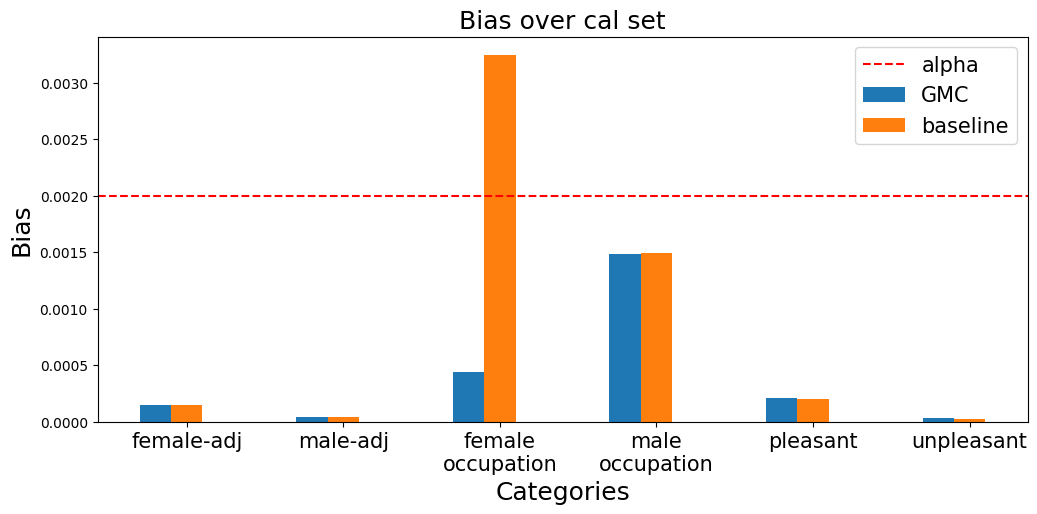

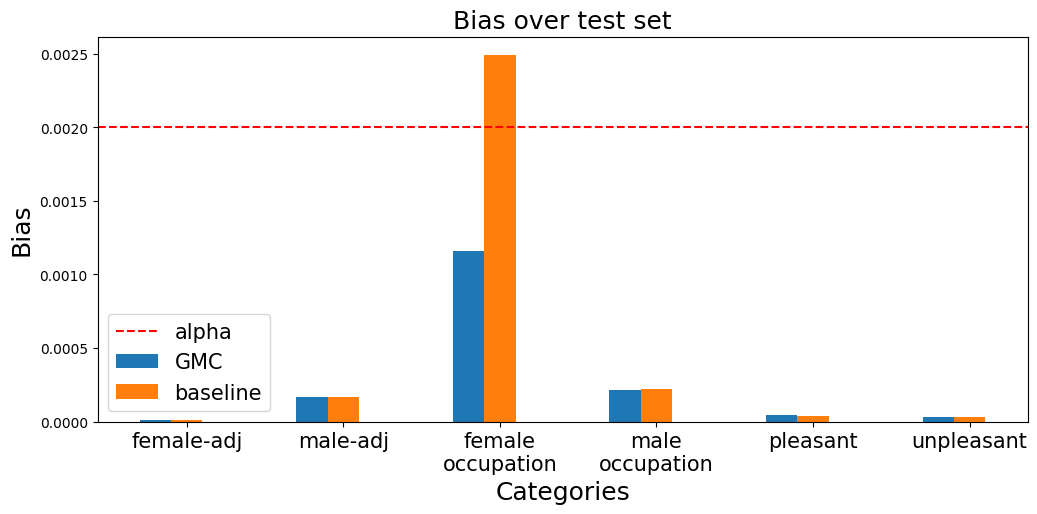

In [42]:
category = ['female-adj', 'male-adj', 'female\noccupation', 'male\noccupation', 'pleasant', 'unpleasant']
select_G = [G[1], G[5], G[9], G[13], G[17], G[21]]
gap_cal = eval(select_G, s, fx, x_s_cal, y_s_cal, p_s_cal)
gap_cal_b = eval(select_G, s, p_s_cal, x_s_cal, y_s_cal, p_s_cal)
gap_test = eval(select_G, s, fx_test, x_s_test, y_s_test, p_s_test)
gap_test_b = eval(select_G, s, p_s_test, x_s_test, y_s_test, p_s_test)
gap_cal, gap_cal_b, gap_test, gap_test_b = abs(gap_cal), abs(gap_cal_b), abs(gap_test), abs(gap_test_b) 
plot_result(category, gap_cal, gap_cal_b, 'Categories', 'Bias', 'Bias over cal set', base=alpha)
plot_result(category, gap_test, gap_test_b, 'Categories', 'Bias', 'Bias over test set', base=alpha)

In [22]:
# eta = 0.0002
eta = 0.001
vocab = 30522
fx, fx_accu = p_s_cal, p_accu_s
j, fx, fx_accu = GMC(3/4*alpha, eta, x_s_cal, y_s_cal, p_s_cal, x_accu_s, p_accu_s, s, G, f=(lambda x:fx), f_test=(lambda x:fx_accu), T=30, proj = projection)
import torch.nn.functional as F
def entropy(f, x, y, p):
    return F.cross_entropy(torch.Tensor(f),torch.Tensor(y).long()).numpy()*p.shape[0]
G_accu = [lambda x,f:1]
accu = eval(G_accu, entropy, fx_accu, x_accu_s, y_accu_s, p_accu_s, accu=True)
accu_b = eval(G_accu, entropy, p_accu_s, x_accu_s, y_accu_s, p_accu_s, accu=True)
print('cross entropy of our algorithm: ', accu)
print('cross entropy of the baseline: ', accu_b)

8
0.853182714604884
8
0.7000171770469961
8
0.6073594332868743
8
0.531797094487789
8
0.4626498860696441
8
0.4003690036746702
13
0.5030314365461789
7
end
cross entropy of our algorithm:  9.955127716064453
cross entropy of the baseline:  9.955095291137695


In [ ]:
from torch.nn.functional import softmax
a = tokenizer(['The accountant ate because he was hungry  .'], return_tensors="pt", padding=True, truncation=True)
a['input_ids'][0,2]=103
a['attention_mask'][0][2]=0
result_a = model(**a)
result_p_a = softmax(result_a.prediction_logits.detach(), dim=-1).numpy()[0,2,:]

In [ ]:
b = tokenizer(['The professor ate because he was hungry  .'], return_tensors="pt", padding=True, truncation=True)
b['attention_mask'][0][2]=0
result_b = model(**b)
result_p_b = softmax(result_b.prediction_logits.detach(), dim=-1).numpy()[0,2,:]

In [ ]:
result_p_a==result_p_b

In [ ]:
tokenizer.decode(y_s[3])

In [ ]:
tokenizer.decode(np.argmax(p_s[3,:]))

In [ ]:
np.max(p_s[3,:])

In [ ]:
np.max(p_s[1,:])